In [15]:
import sys
sys.path.append('../')

import torch as tc
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from rcgp.experimental import SpatioTemporalRCGP
from rcgp.kernels import Matern32Kernel

In [16]:
def generate_data(lengthscale=0.4, magnitude=2., var_y = 0.02):
    tc.manual_seed(42)  # For reproducibility
    x = tc.linspace(0, 1, 100) 
    kernel = Matern32Kernel(lengthscale=tc.tensor(lengthscale), magnitude=tc.tensor(magnitude))

    cov_matrix, mean = kernel.forward(x.reshape(-1,1), x.reshape(-1,1)) + 1e-5 * tc.eye(len(x)), tc.zeros(x.shape)

    true_f = tc.distributions.MultivariateNormal(mean, cov_matrix).sample()
    true_f = true_f - true_f.mean()

    noise = tc.distributions.Normal(0, var_y).sample(true_f.shape)
    y = true_f + noise

    return x, y, true_f

def add_outliers(y):
    tc.manual_seed(10)

    y_outliers = y.clone().detach()
    outliers_loc = [50, 51, 53, 54, 57, 59, 65]
    outliers_loc = [50, 51, 53, 54, 55, 56, 57, 59, 65]

    noise = tc.distributions.Normal(loc=0, scale=20.).sample((len(outliers_loc), ))
    y_outliers[outliers_loc] = y_outliers[outliers_loc] + noise
    return y_outliers, outliers_loc

true_lengthscale, true_magnitude, true_var_y = (0.2, 2., 0.25)
Xs, Ys, true_func = generate_data(lengthscale=true_lengthscale, magnitude=true_magnitude, var_y=true_var_y)
Ys_outliers, outliers_loc = add_outliers(Ys)

# Optimization

In [17]:
def scoring_rule(Ys : tc.Tensor, preds : tc.Tensor, covs : tc.Tensor, R : tc.Tensor, Ws: tc.Tensor):
    S = covs + R
    eps = (Ys - preds).unsqueeze(-1)

    mahalanobis_dist = (eps.mT @ tc.linalg.inv(S) @ eps).squeeze()
    norm_const = tc.logdet(2 * tc.pi * S)

    energies = 0.5 * (norm_const + mahalanobis_dist)
    Ws = (Ws / Ws.sum()).squeeze()
    
    return tc.dot(Ws, energies)

def coverage(preds, std, Ys):
    quantiles = np.append(np.arange(0.05, 1, 0.05), 0.9973)
    coverage_vals = []
    for confidence_level in quantiles:
        z_val = norm.ppf(1 - (1 - confidence_level)/2)
        lb = preds - z_val * std
        ub = preds + z_val * std

        is_within_bounds = (Ys >= lb) & (Ys <= ub)
        coverage_vals.append(is_within_bounds.mean())
    
    return quantiles, coverage_vals


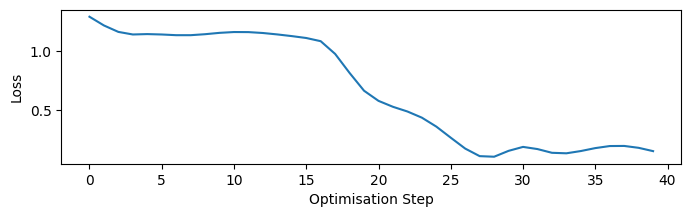

In [18]:
lr = 0.5 #Learning Rate
n_steps=40 #Number of Optimisation Steps
verbose=False #To print loss/params at each # steps
losses = [] #For plotting losses
adaptive_c = True #If c is adaptive. If this is True c = ... below is overwritten/not used
robust, robust_func = True, "m_pred" #If robust, it's the ST-RCGP with specified robust function. If not, STGP, and c/beta are not used, and weights=1
outliers = False #If we want to fit outliers
c = 5. #If we set adaptive_c = False, this value becomes relevant. If c=None, defaults to 2 * sqrt(var_y)

if outliers:
    strcgp = SpatioTemporalRCGP(ts=Xs.reshape(-1,1), grid=None, Ys=Ys_outliers.reshape(-1,1), p=1)
else:
    strcgp = SpatioTemporalRCGP(ts=Xs.reshape(-1,1), grid=None, Ys=Ys.reshape(-1,1), p=1)

strcgp.c = c
if adaptive_c: strcgp.adaptive_c()
if robust: strcgp.activate_robustness(func=robust_func)

optimizer = tc.optim.Adam(strcgp.parameters(), lr=lr)

for step in range(n_steps):
    _,(preds, covs, R, Ws), _ = strcgp.forward()
    loss = scoring_rule(Ys=Ys.reshape(-1,1), preds=preds, covs=covs, R=R, Ws=Ws)
    loss.backward()
    losses.append(loss.clone().detach())
    optimizer.step()  # Update parameters
    optimizer.zero_grad()  # Reset gradients

    if verbose and step%5==0:
        print(f"---------step {step}----------")
        print("Loss : {}".format(loss.detach().clone()))

        for name, param in strcgp.named_parameters():
            if param.requires_grad:
                print(f"{name}: {param.data}")
        print("-------------------------\n")

plt.figure(figsize=(8,2))
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Optimisation Step");

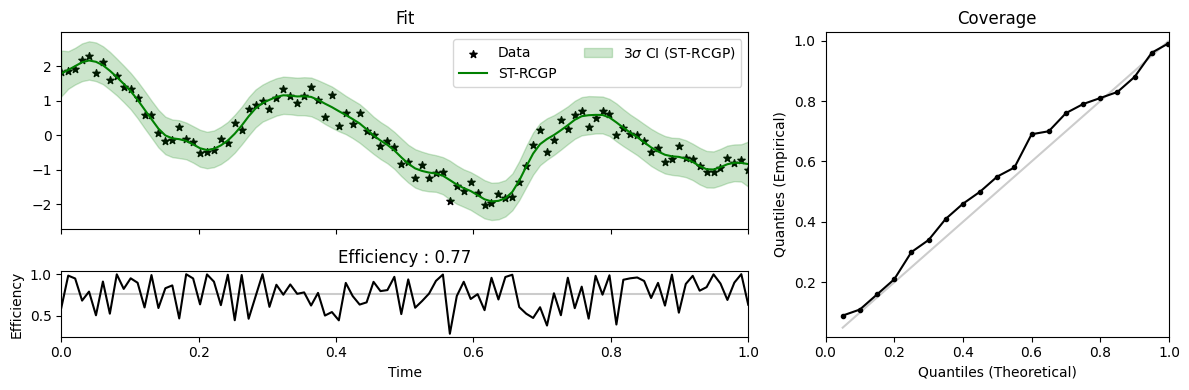

In [19]:
with tc.no_grad(): 
    (pred_strcgp, std_strcgp, strcgp_eff), _, _ = strcgp.forward()
    pred_strcgp = pred_strcgp.squeeze().numpy()
    #std_strcgp = std_strcgp.squeeze().numpy()
    std_strcgp = tc.sqrt(strcgp.var_y.clone().detach() + std_strcgp**2).numpy()
    
quantiles, coverage_vals = coverage(pred_strcgp, std_strcgp, Ys.numpy())

# Create a mosaic layout
fig, axs = plt.subplot_mosaic(
    [
        ["top_left", "quantile"],
        ["bottom_left", "quantile"]
    ],
    figsize=(12, 4),
    sharex=True,
    gridspec_kw={"width_ratios": [2, 1], "height_ratios": [3, 1]}
)

# Top Left Plot
if outliers:
    colors = ['black' if i not in outliers_loc else (0,0,0,0.1) for i in range(len(Xs))]
    axs['top_left'].scatter(Xs, Ys, c=colors, s=30, marker='*', label="Data")
    axs['top_left'].scatter(Xs[outliers_loc], Ys_outliers[outliers_loc], c='red', s=30, marker='*', label="Outliers")
else:
    axs['top_left'].scatter(Xs, Ys, s=30, c='black', marker='*', label="Data")


axs['top_left'].plot(Xs, pred_strcgp, 'g-', label="ST-RCGP")
axs['top_left'].fill_between(Xs, pred_strcgp - 3 * std_strcgp, pred_strcgp + 3 * std_strcgp, color='g', alpha=0.2, label=r"$3\sigma$ CI (ST-RCGP)")
if outliers: axs['top_left'].set_yscale('symlog')
axs['top_left'].legend(ncol=2)
axs['top_left'].set_title("Fit")

# Top Right Plot
axs["quantile"].set_title("Coverage")
axs["quantile"].plot(quantiles, coverage_vals, "k.-")
axs["quantile"].plot(quantiles, quantiles, "k-", alpha=0.2)
axs["quantile"].set_xlabel("Quantiles (Theoretical)")
axs["quantile"].set_ylabel("Quantiles (Empirical)")
nudge = 0.03
axs["quantile"].set_xlim(quantiles[0]-nudge, quantiles[-1]+nudge)
axs["quantile"].set_ylim(quantiles[0]-nudge, quantiles[-1]+nudge)

# Bottom Left Plot
axs["bottom_left"].plot(Xs, strcgp_eff, color="black")
mean_eff = strcgp_eff.mean()
axs["bottom_left"].hlines(mean_eff, xmin=Xs[0], xmax=Xs[-1], color='black', alpha=0.2)
axs["bottom_left"].set_xlim(Xs[0], Xs[-1])
axs["bottom_left"].set_title(f"Efficiency : {mean_eff:.2f}")
axs["bottom_left"].set_ylabel("Efficiency")
axs["bottom_left"].set_xlabel("Time")

# Adjust layout
plt.tight_layout()